### Are preference selective units identified from ANOVA also belief selective?
- Take a look at a few examples
- From visualization, think about: what is the relationship between belief, preference, value? 

In [9]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools
from scipy import stats


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Plotting function: 

In [21]:
def plot(args, unit_row):
    unit_id = int(unit_row.PseudoUnitID)
    args.feat = unit_row.feat
    fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey="row")

    args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
    data = load_data(int(unit_id / 100), args)
    data = data[data.PseudoUnitID == unit_id]
    cond_order = np.sort(data["FeatPreferred"].unique())

    sns.lineplot(data, x="Time", y="FiringRate", hue="FeatPreferred", hue_order=cond_order, errorbar="se", ax=axs[0, 0])
    sns.barplot(data, x="FeatPreferred", y="FiringRate", ax=axs[1, 0], order=cond_order)

    args.beh_filters = {}
    beh, frs = load_data(int(unit_id / 100), args, return_merged=False)
    beh[f"{args.feat}LogProb"] = np.log(beh[f"{args.feat}Prob"])

    visualization_utils.visualize_cond_psth(beh, frs, unit_id, f"{args.feat}Prob", axs[0, 1], num_bins=10)
    r, p = visualization_utils.visualize_cond_correlations(beh, frs, unit_id, f"{args.feat}Prob", axs[1, 1])
    axs[1, 1].set_title(f"r: {r:.3f}, p: {p:.3E}")

    # visualization_utils.visualize_cond_psth(beh, frs, unit_id, f"{args.feat}LogProb", axs[0, 2], num_bins=10)
    # r, p = visualization_utils.visualize_cond_correlations(beh, frs, unit_id, f"{args.feat}LogProb", axs[1, 2])
    # axs[1, 2].set_title(f"r: {r:.3f}, p: {p:.3E}")
    sub_beh = beh[beh.FeatPreferred == "Preferred"]
    visualization_utils.visualize_cond_psth(sub_beh, frs, unit_id, f"{args.feat}Prob", axs[0, 2], num_bins=10)
    r, p = visualization_utils.visualize_cond_correlations(sub_beh, frs, unit_id, f"{args.feat}Prob", axs[1, 2])
    axs[1, 2].set_title(f"Preferred, r: {r:.3f}, p: {p:.3E}")

    axs[0, 0].set_title(f"{unit_id}, {unit_row.feat}/correct, var: {unit_row.combined_fracvar:.3f}, {unit_row.structure_level2}")
    fig.tight_layout()

### Load units that are selective prior to Stim Onset

In [22]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "StimOnset"
args.conditions = ["FeatPreferred"]
# args.conditions = ["Response", "Choice"]
args.time_range = [-1000, 0]
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
good_pref_stim_res = io_utils.read_anova_good_units(args, "99th")

### Plotting: 
- Preference selectivity on the left
- Belief selectivity on the right
- maybe include raster plots on the bottom


/src/wcst_decode/utils/visualization_utils.py:458: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beh[f"{cond}Label"] = bins[out]
/src/wcst_decode/utils/visualization_utils.py:458: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beh[f"{cond}Label"] = bins[out]
/src/wcst_decode/utils/visualization_utils.py:458: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

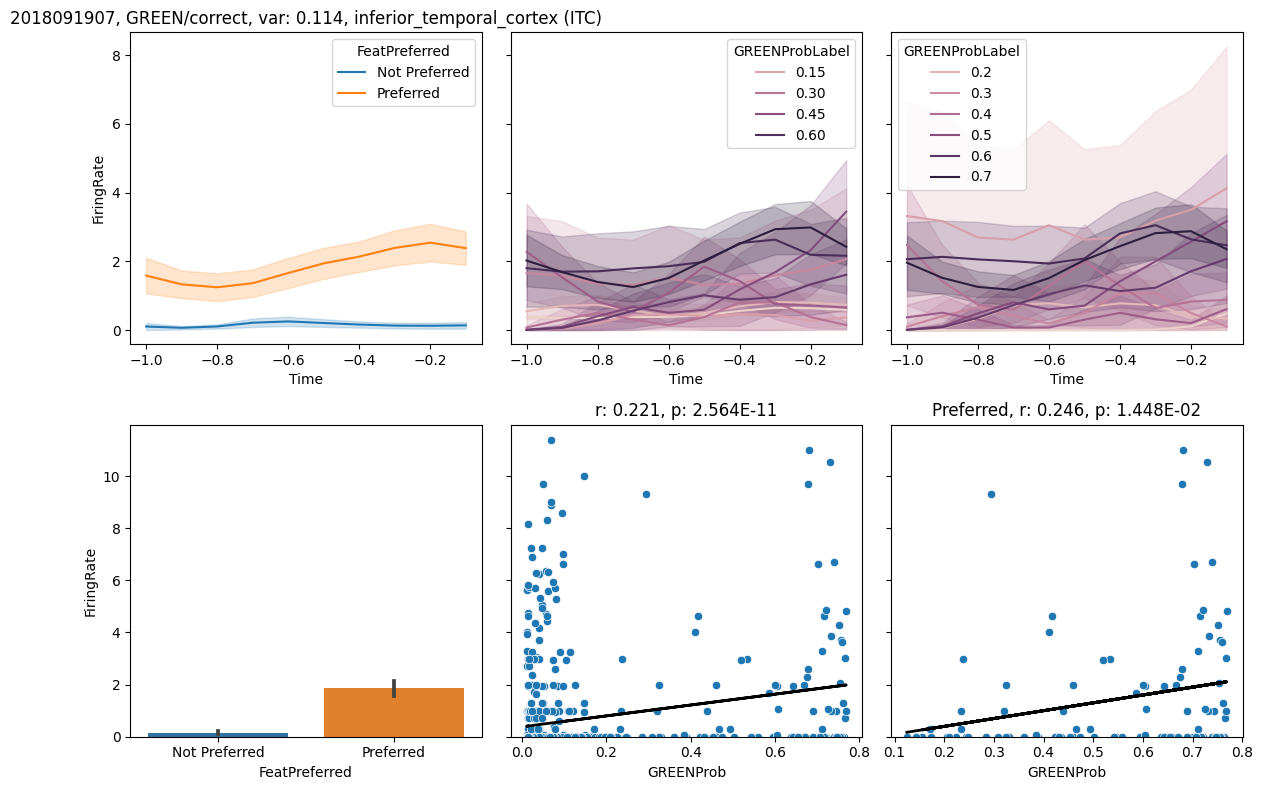

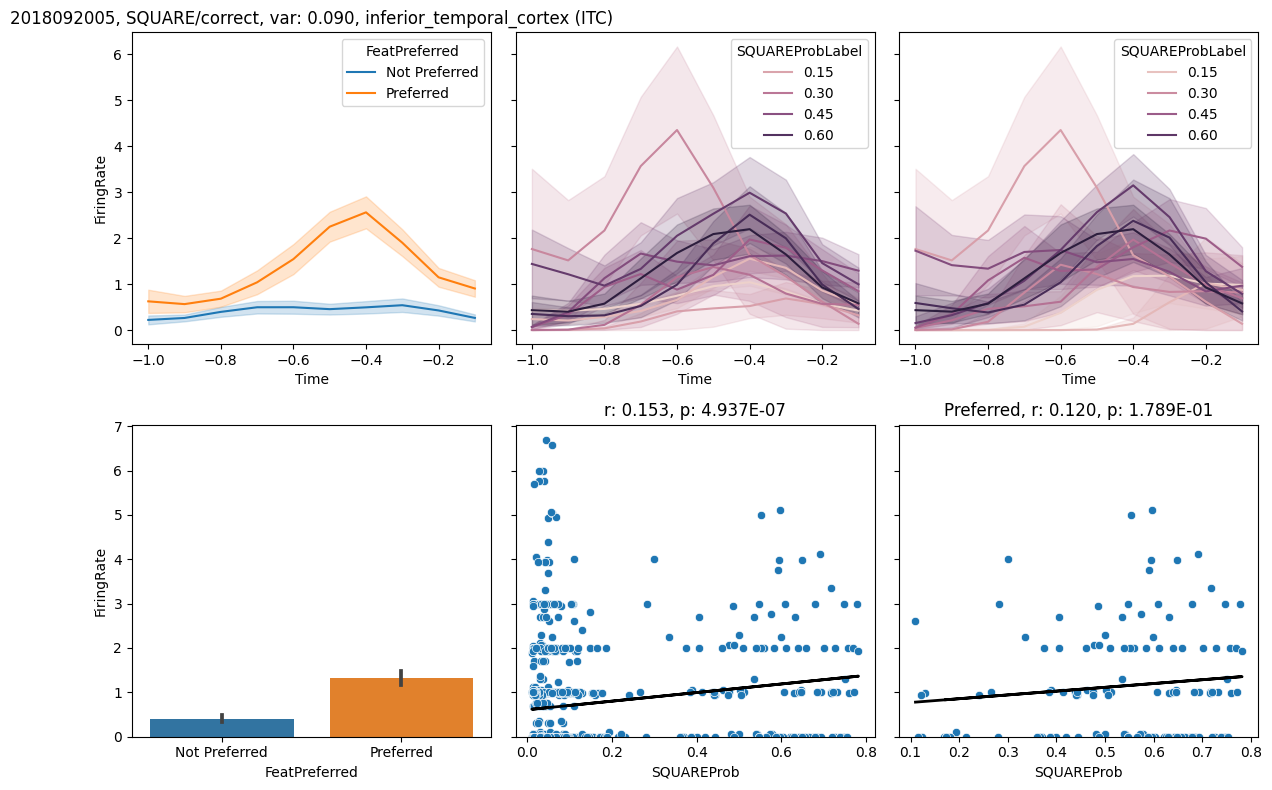

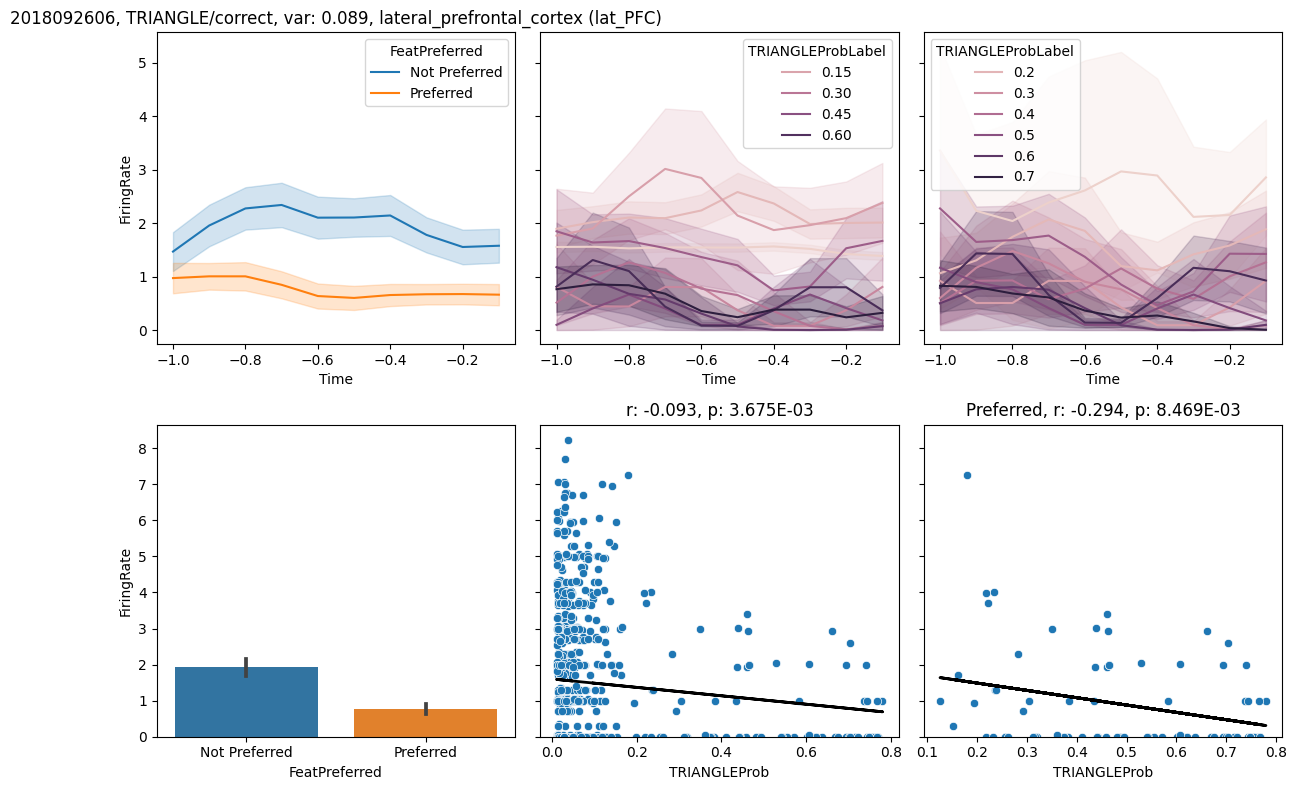

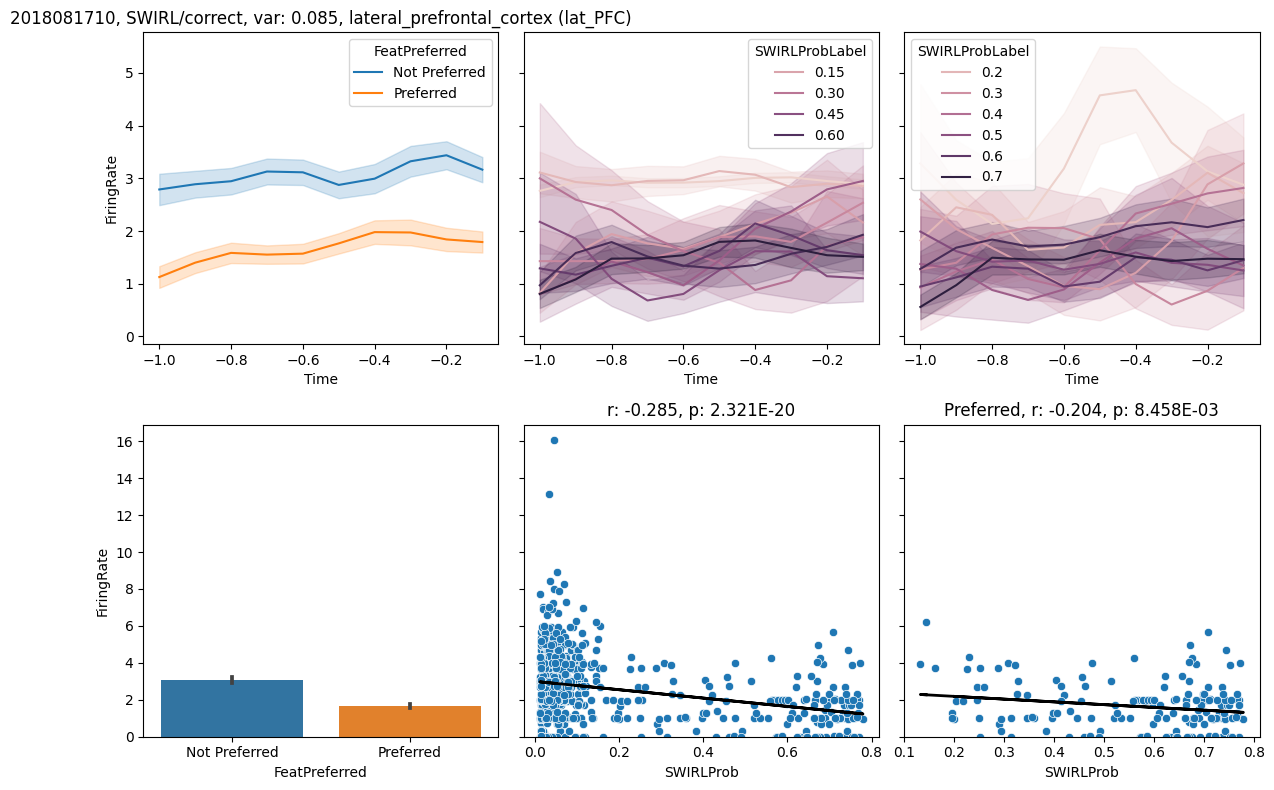

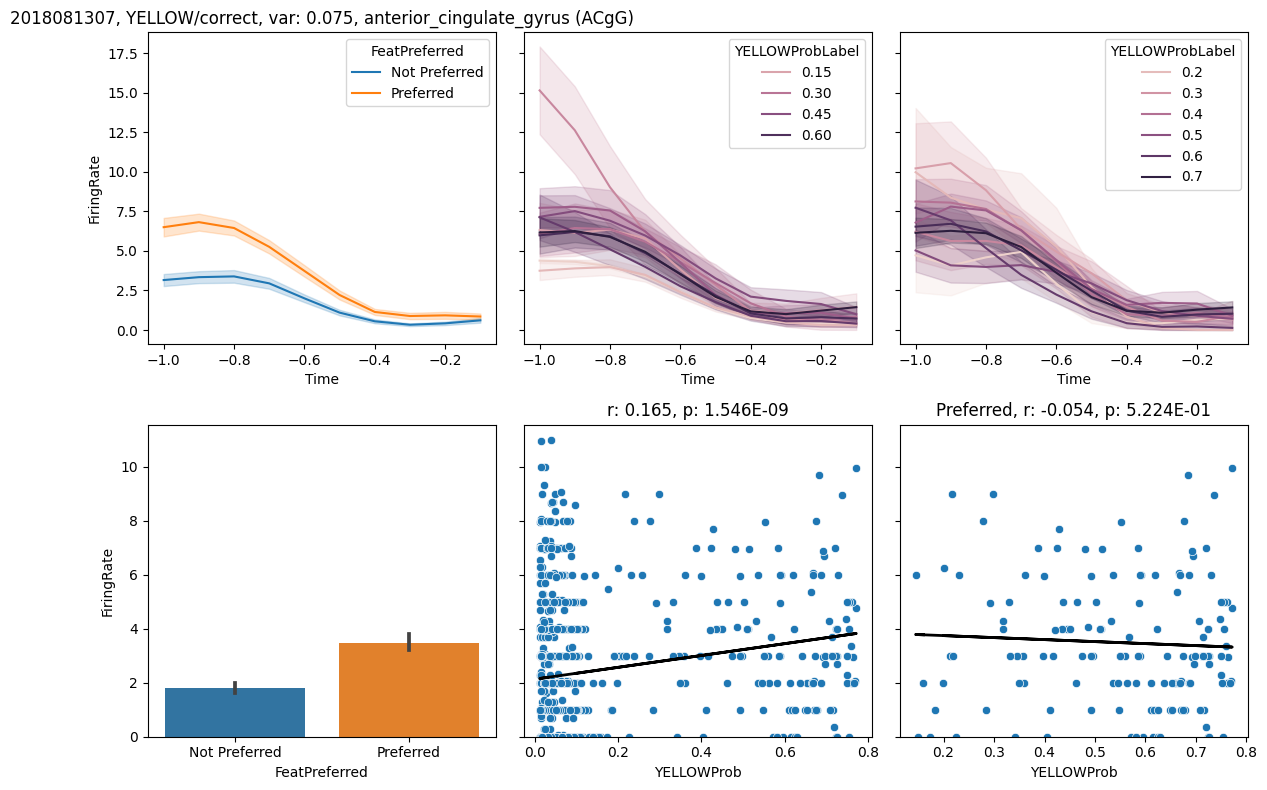

In [23]:
to_vis = good_pref_stim_res.sort_values("combined_fracvar", ascending=False)[:5]
args.time_range = [-1000, 0]
for i, unit in to_vis.iterrows():
    plot(args, unit)

### What about units during feedback

In [16]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.conditions = ["FeatPreferred"]
# args.conditions = ["Response", "Choice"]
args.time_range = [0, 1500]
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
good_pref_fb_res = io_utils.read_anova_good_units(args, "99th")

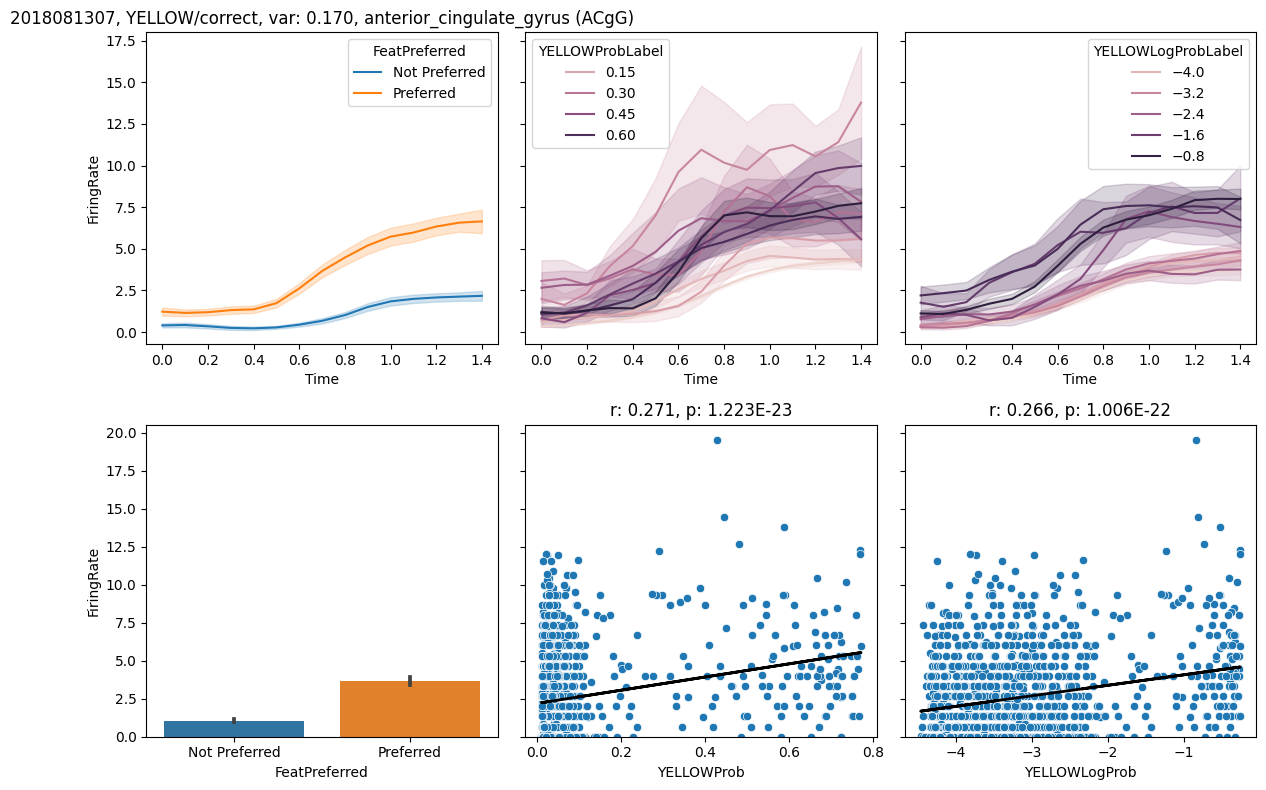

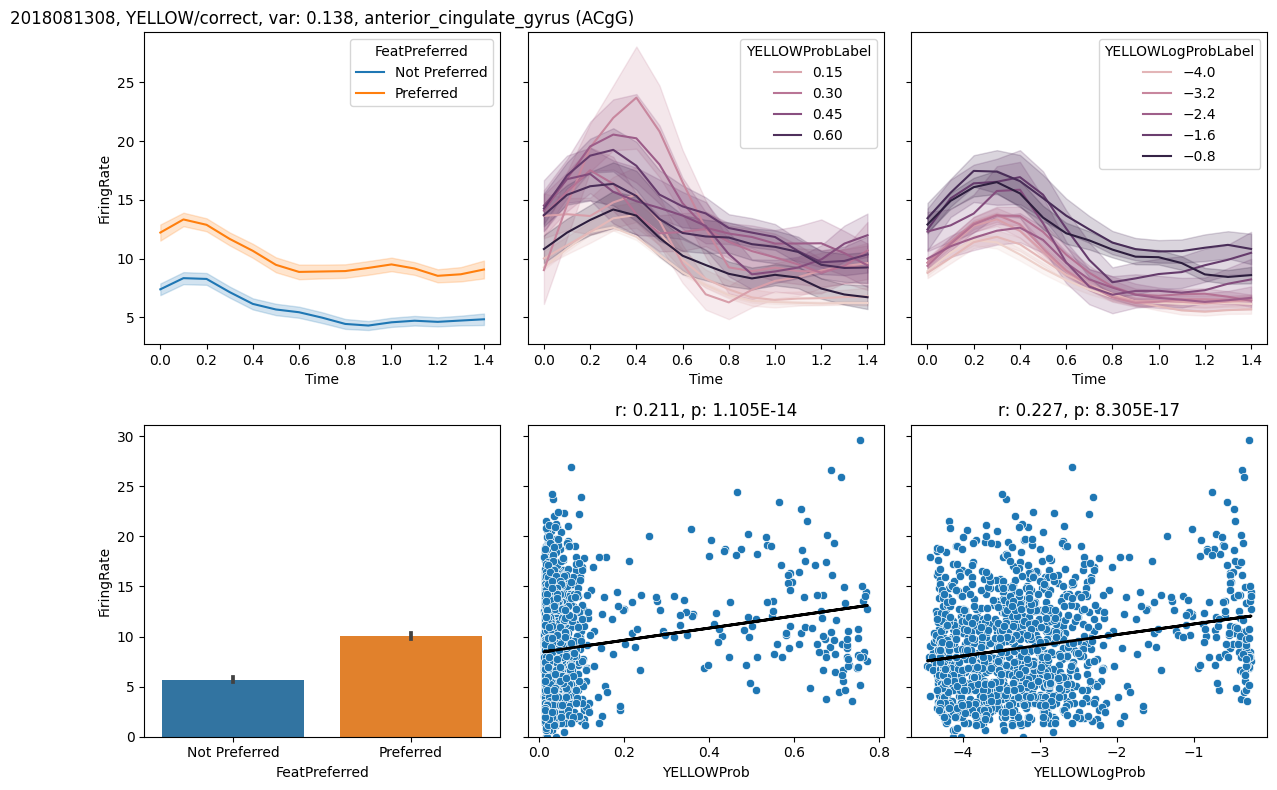

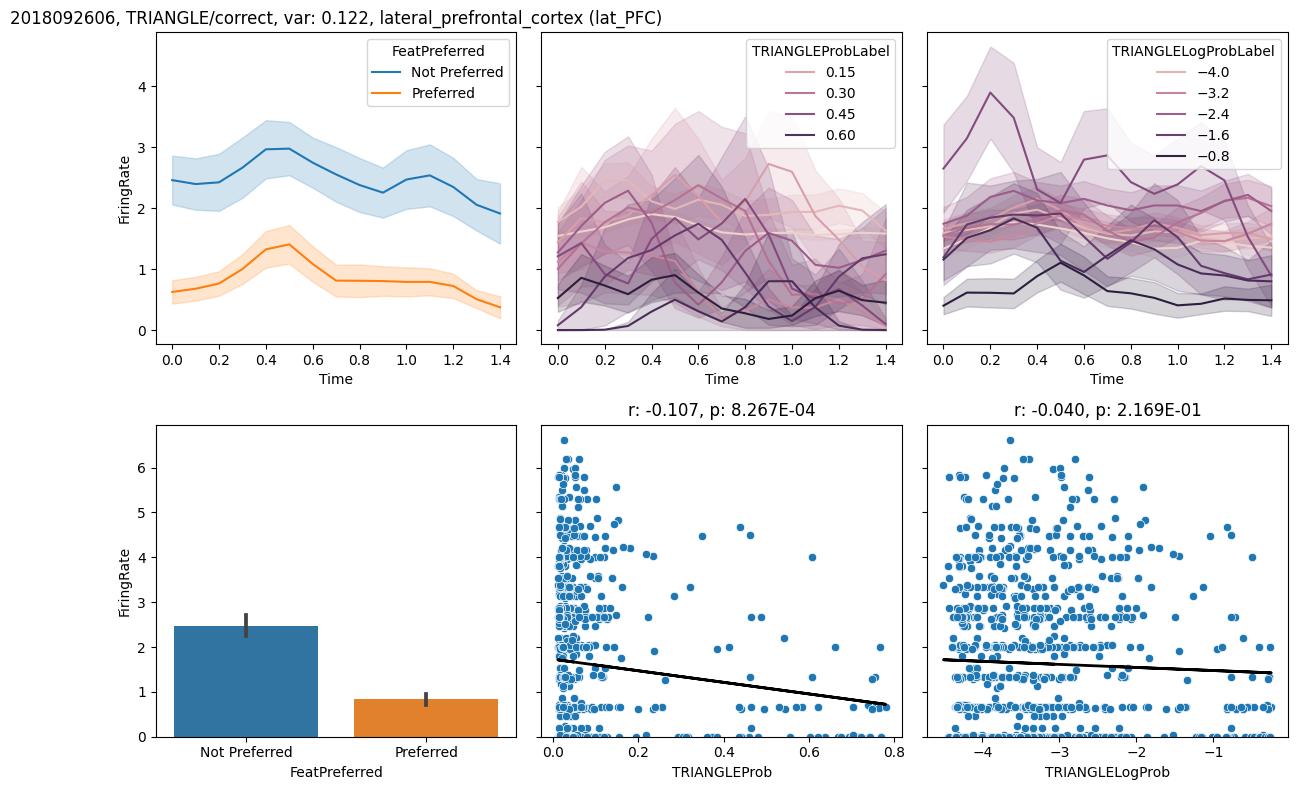

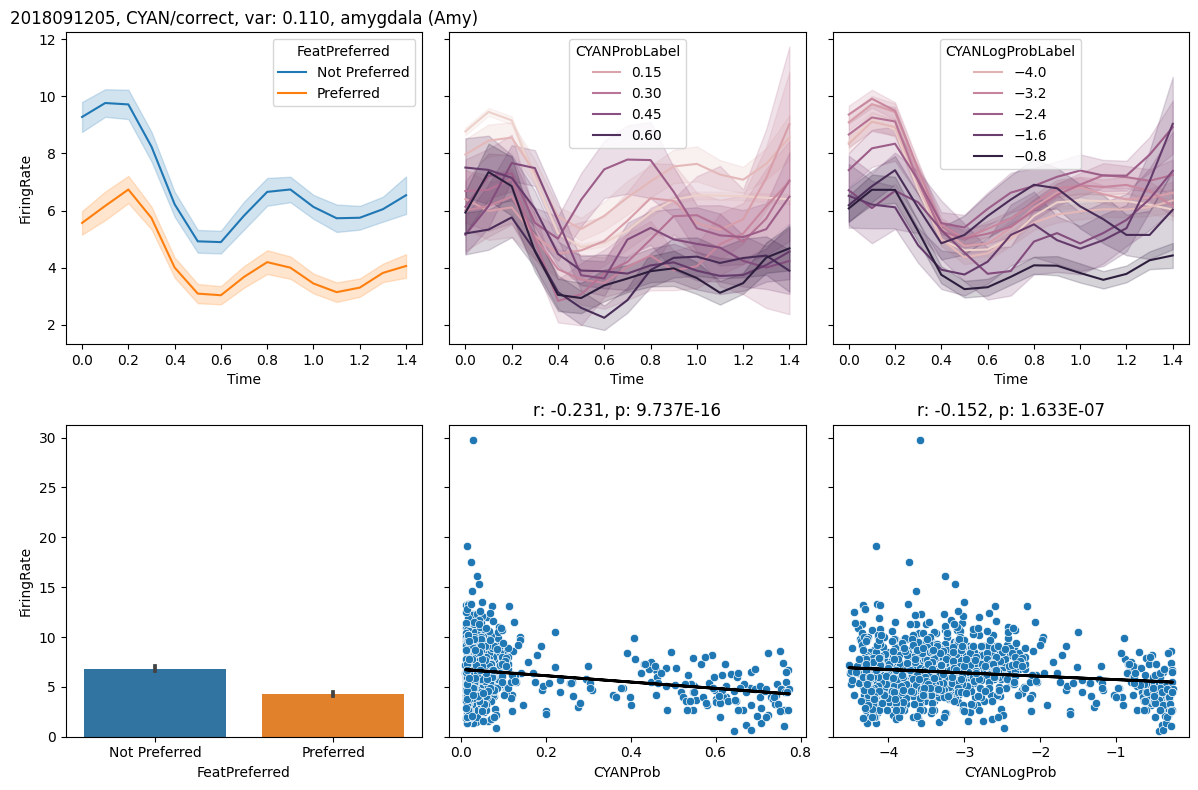

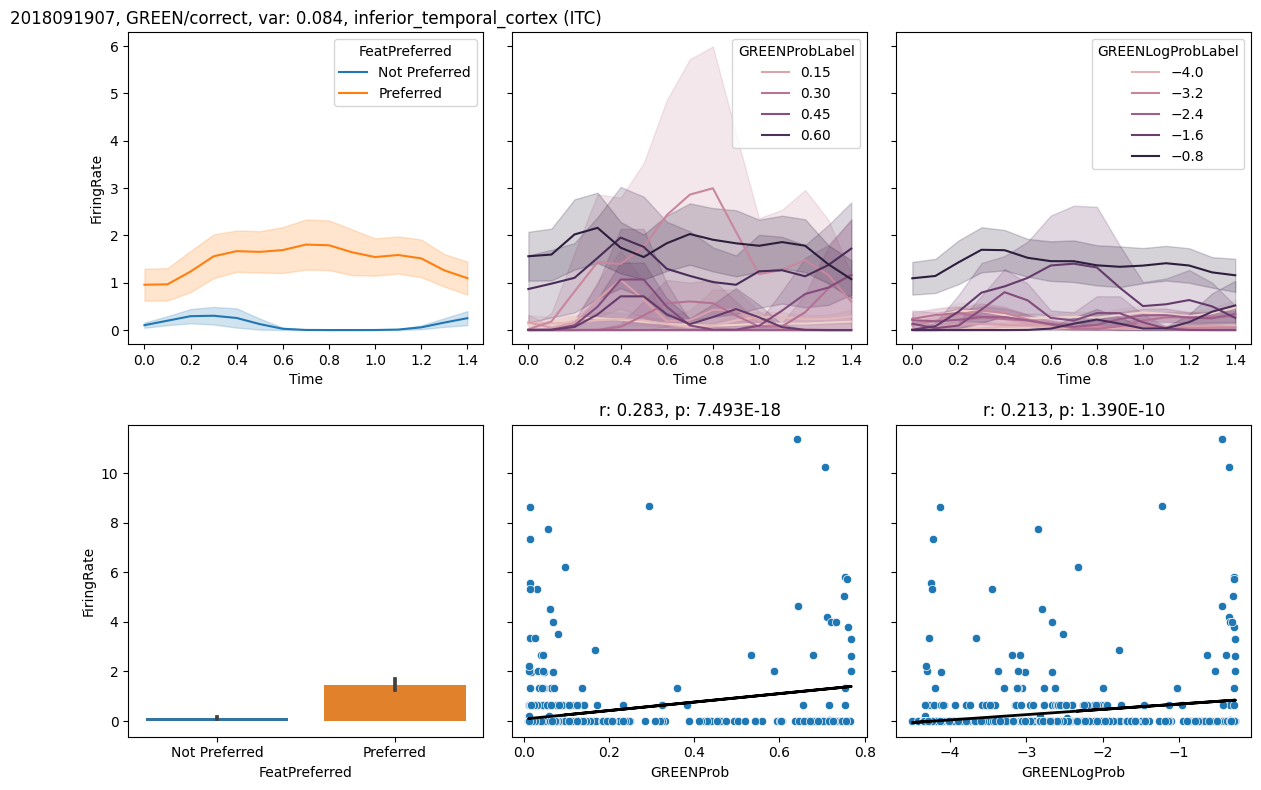

In [17]:
to_vis = good_pref_fb_res.sort_values("combined_fracvar", ascending=False)[:5]
args.time_range = [0, 1500]
for i, unit in to_vis.iterrows():
    plot(args, unit)

### In situations where there's another feature in the session with more than 3 blocks, is the unit selective for that feature's beliefs too?

In [7]:
FEATS_PATH = "/data/patrick_res/sessions/SA/feats_at_least_3blocks.pickle"
feat_sessions = pd.read_pickle(FEATS_PATH).explode("sessions")
feat_sessions["session"] = feat_sessions.sessions.astype(int)

In [8]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "StimOnset"
args.conditions = ["FeatPreferred"]
# args.conditions = ["Response", "Choice"]
args.time_range = [-1000, 0]
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
good_pref_stim_res = io_utils.read_anova_good_units(args, "99th")
good_pref_stim_res["session"] = (good_pref_stim_res.PseudoUnitID / 100).astype(int)
to_vis = good_pref_stim_res.sort_values("combined_fracvar", ascending=False)[:10]


### Plots

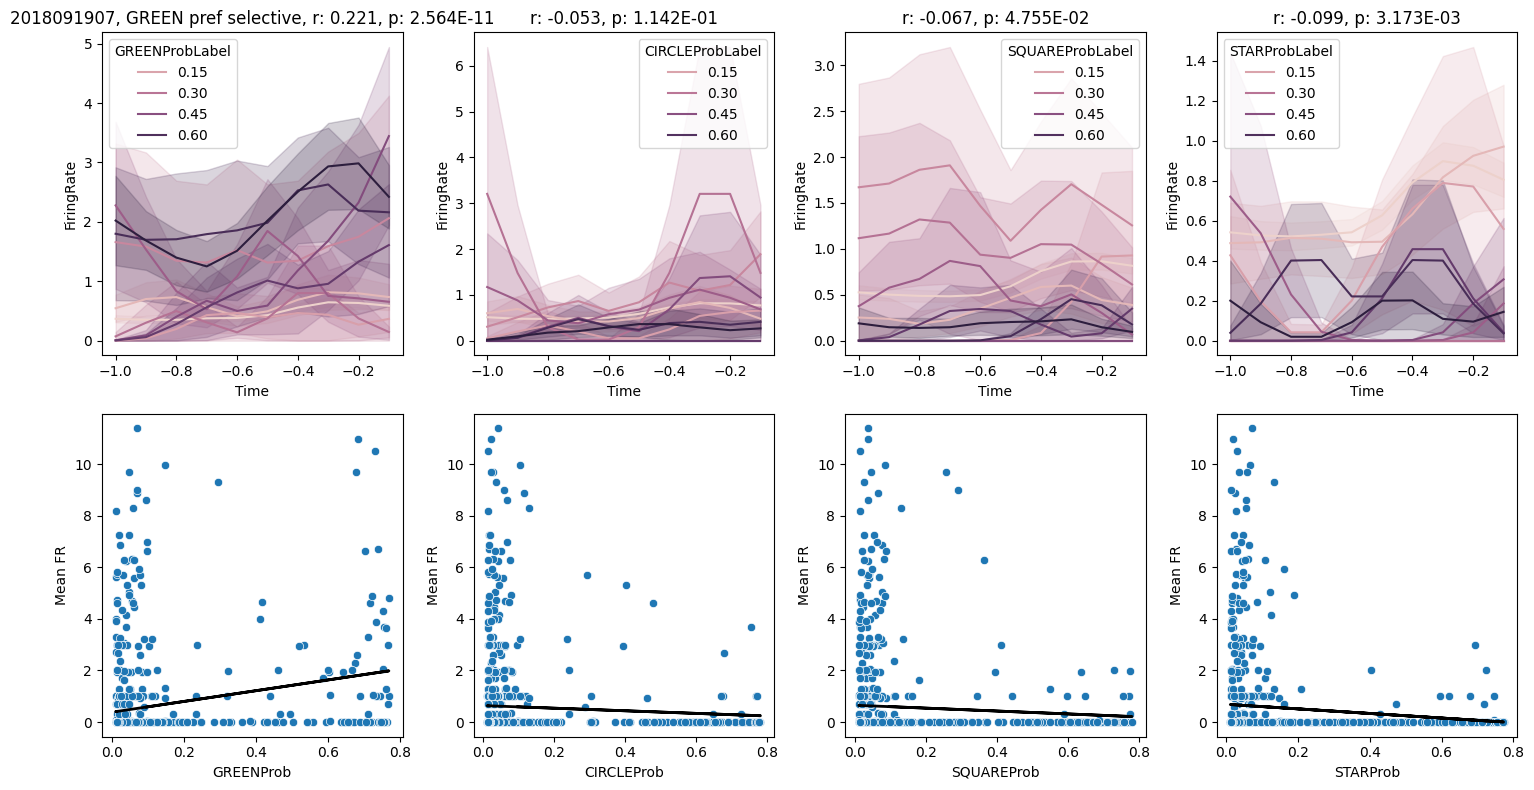

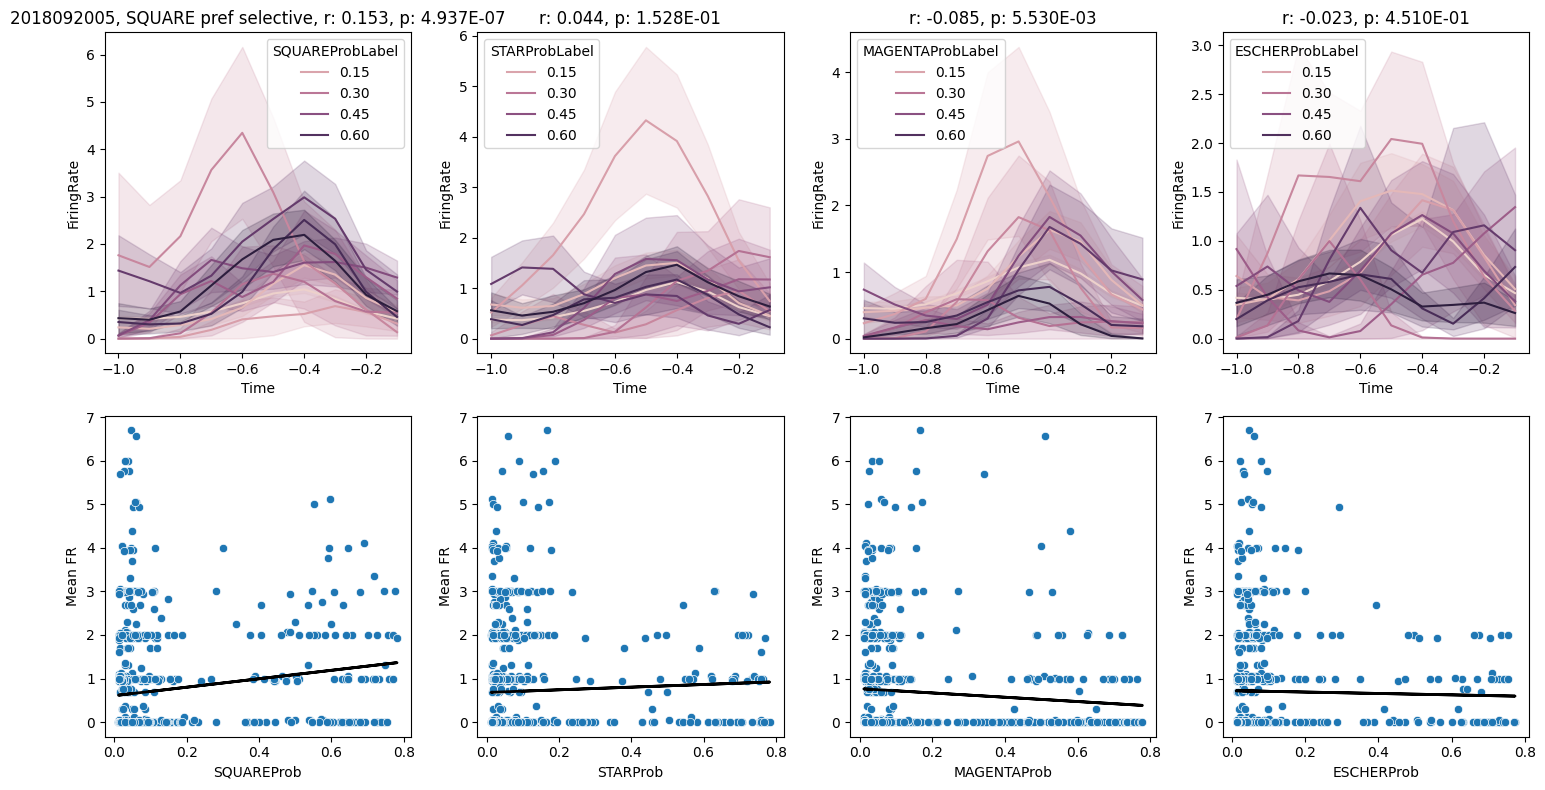

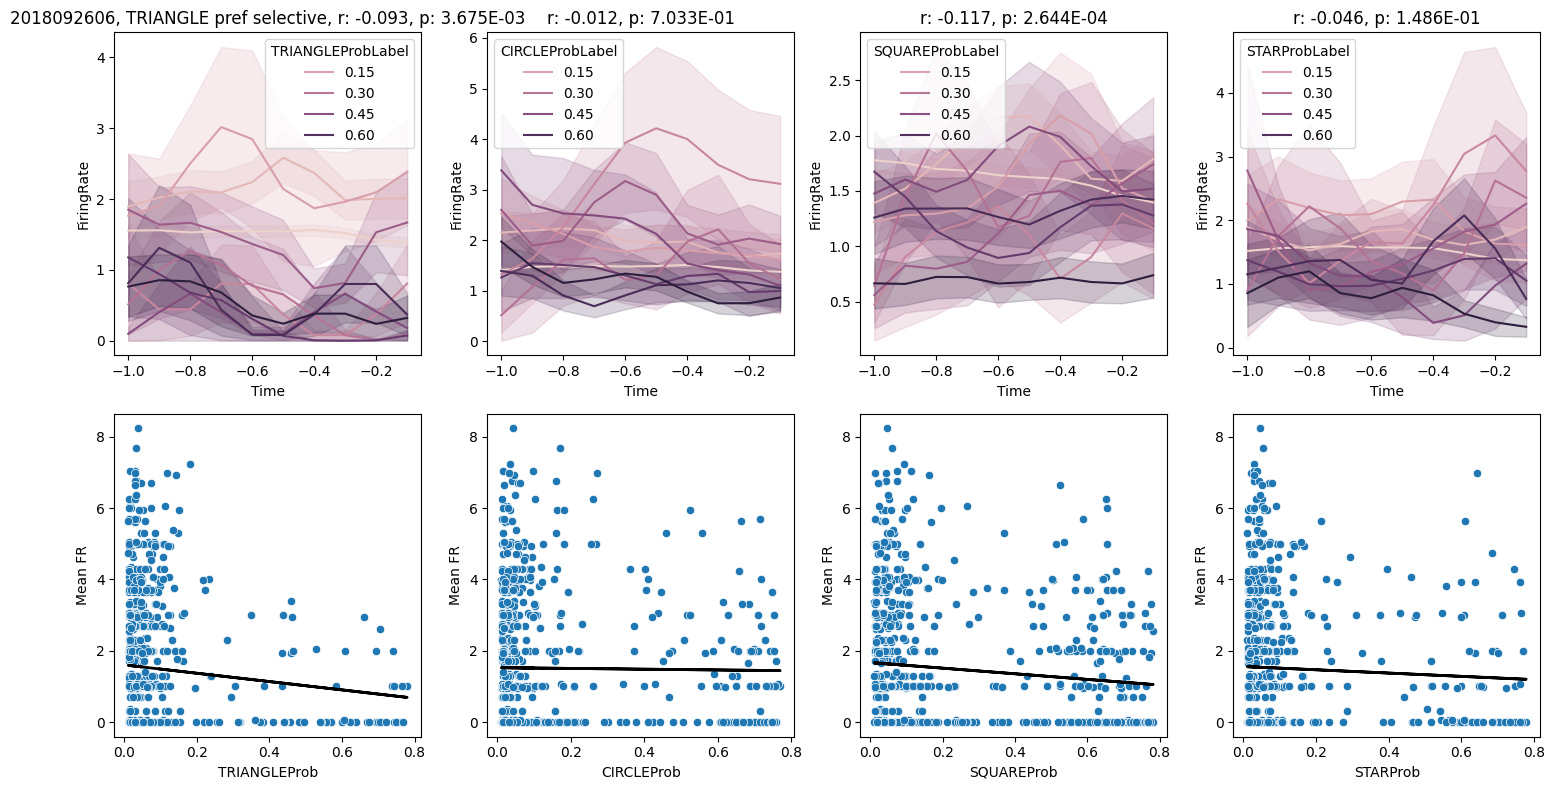

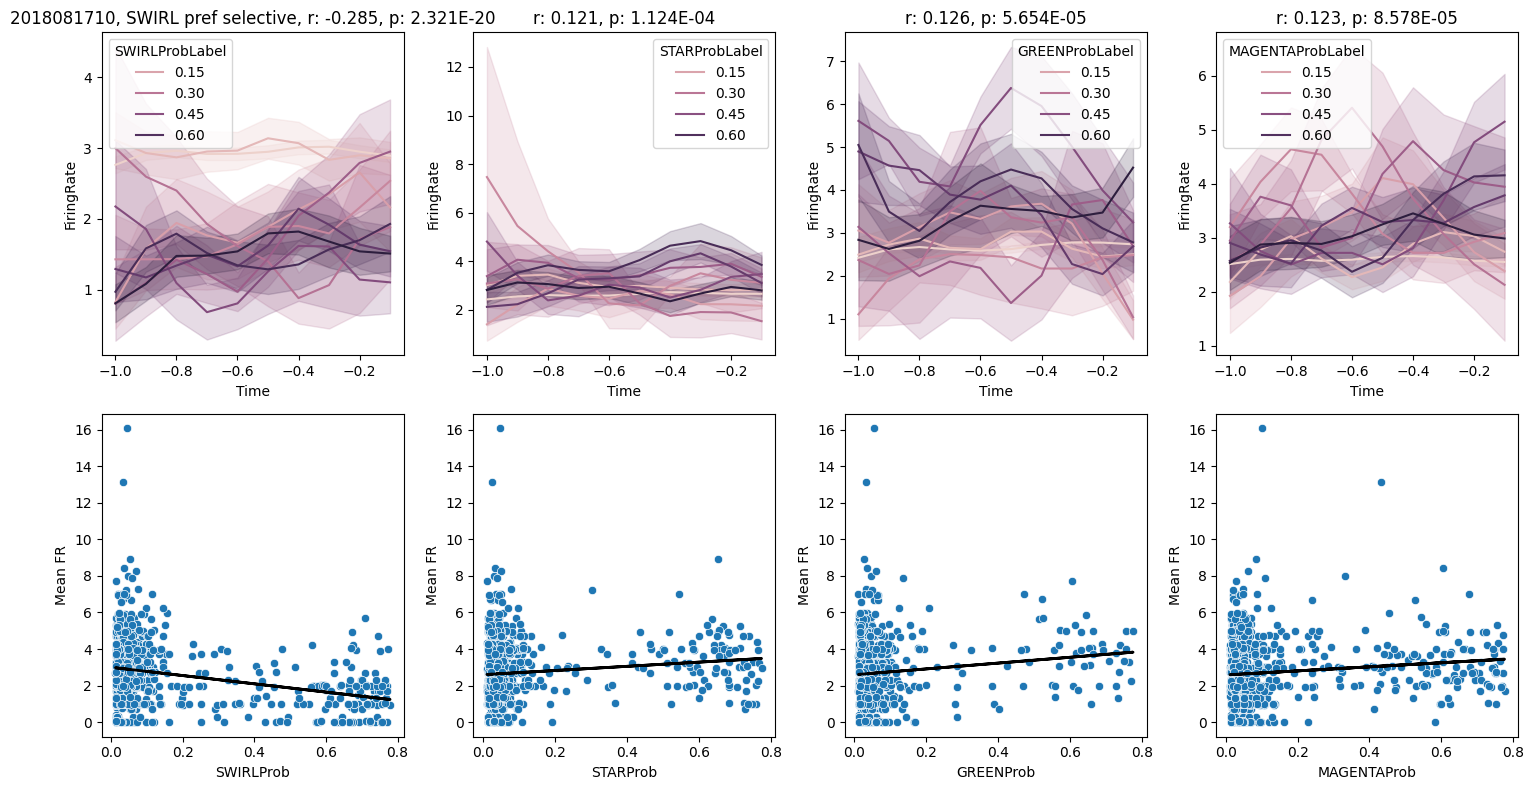

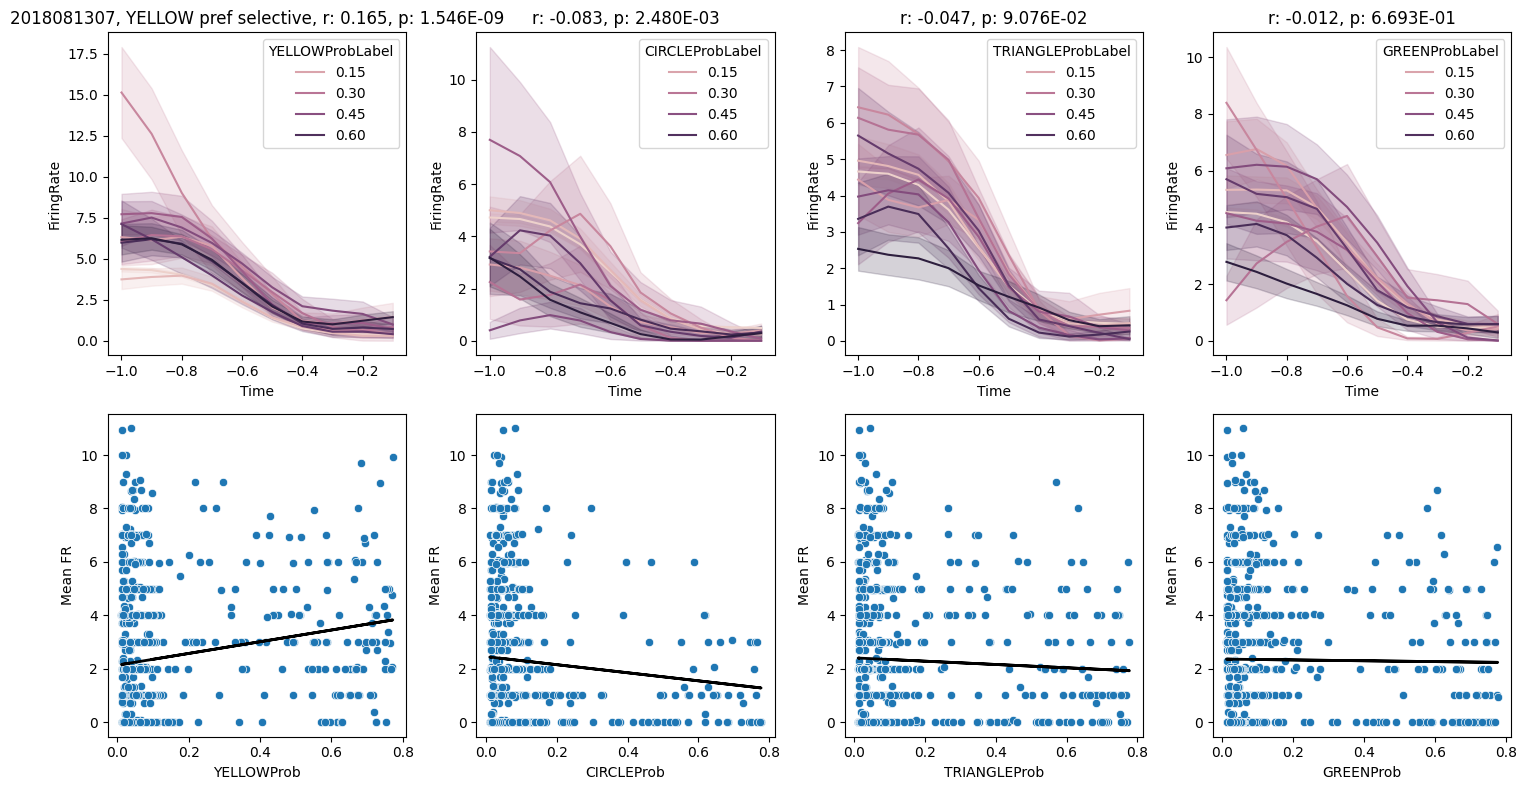

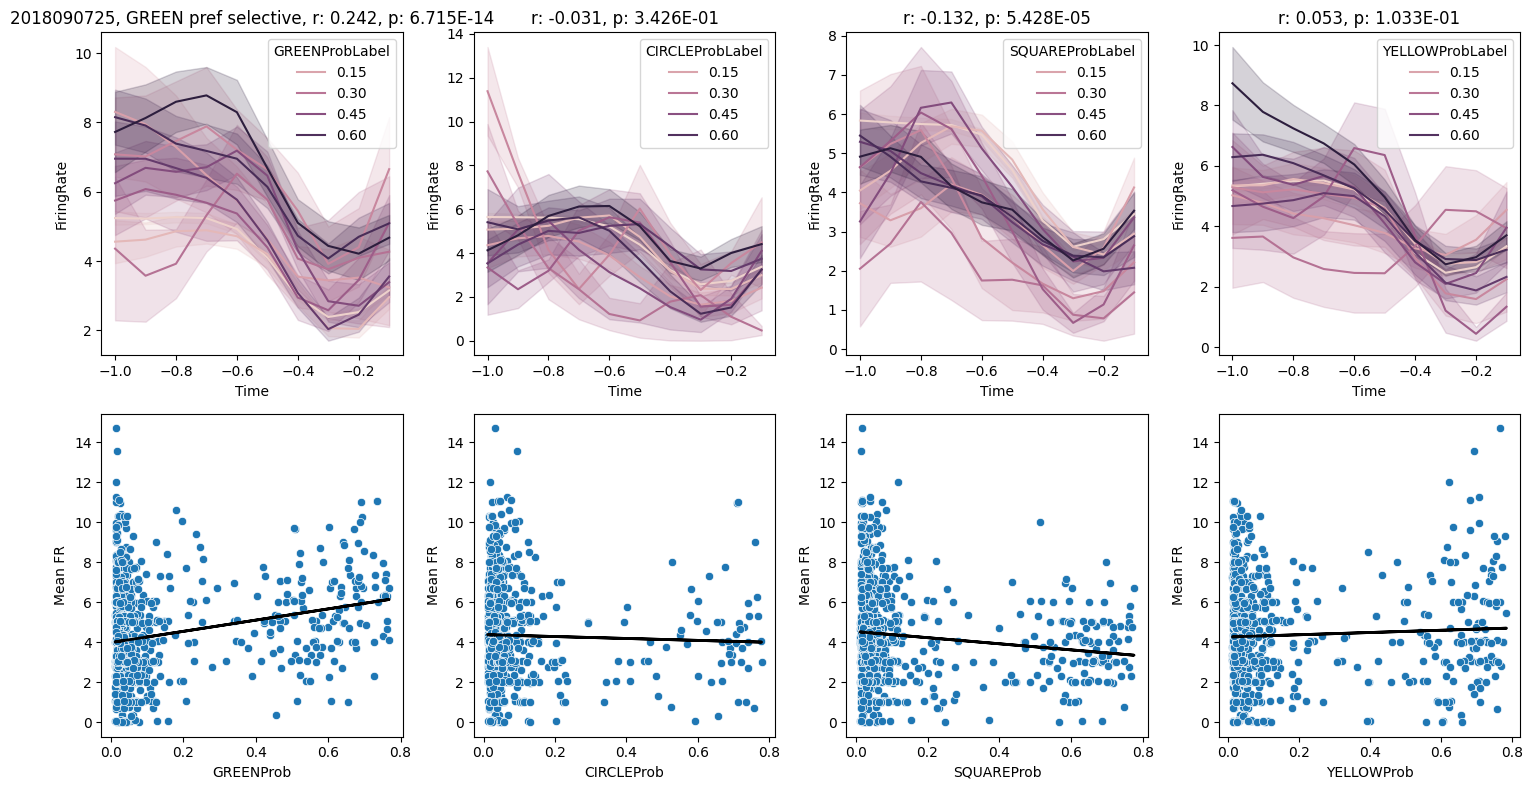

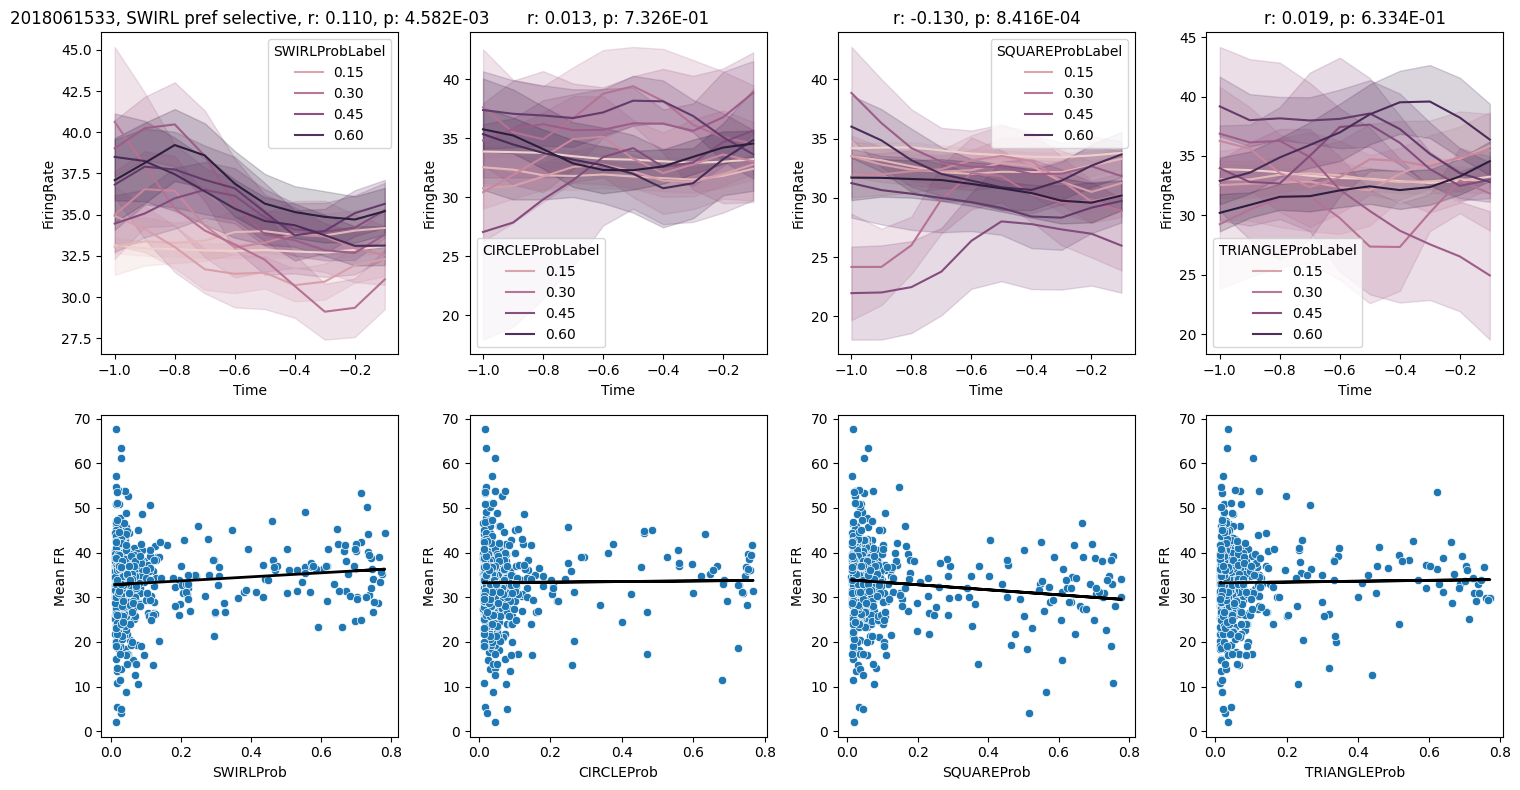

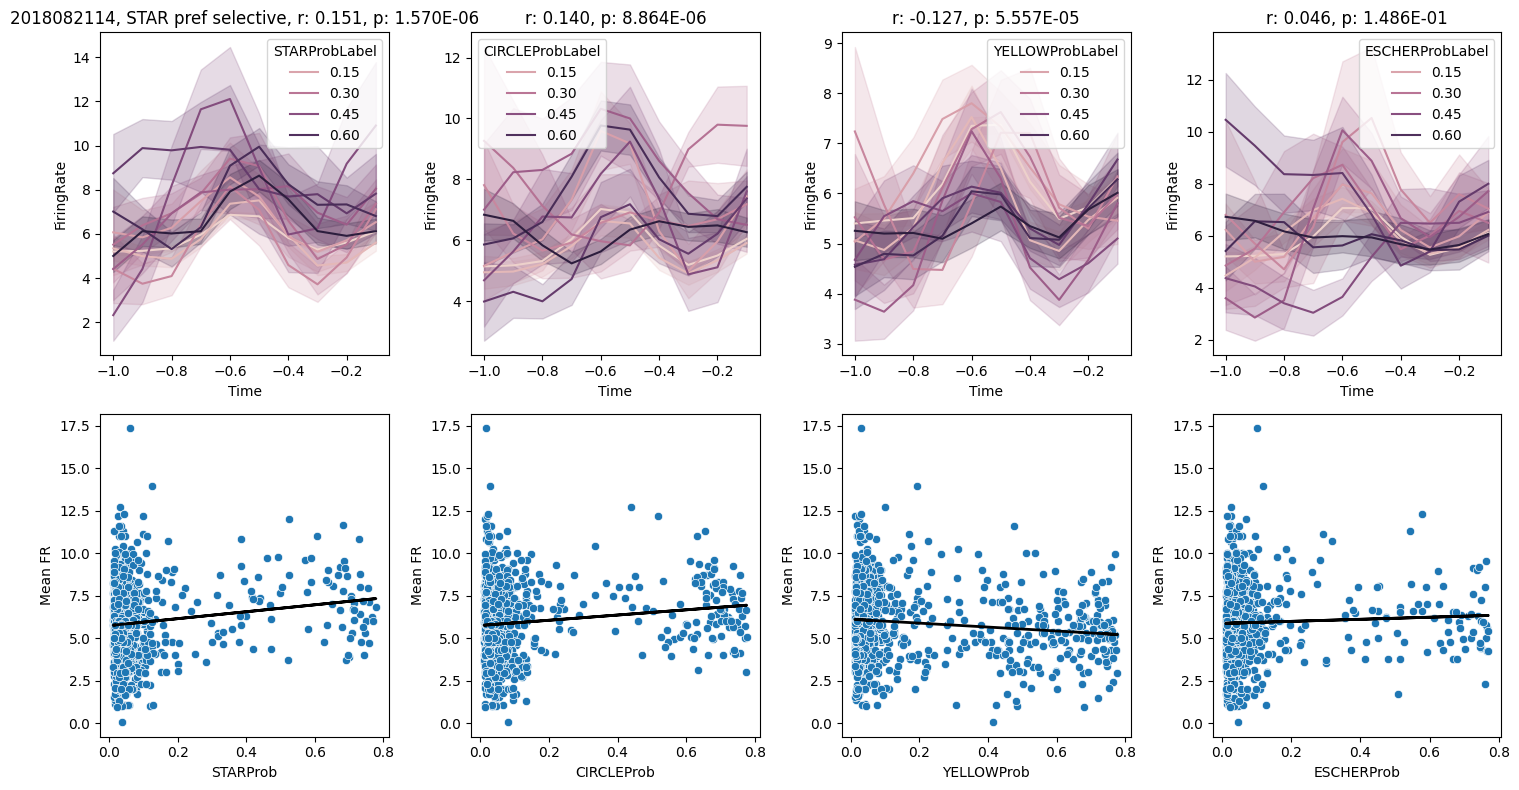

In [8]:
num_other_feats = 3
for i, row in to_vis.iterrows():
    other_feats = feat_sessions[(feat_sessions.session == row.session) & (feat_sessions.feat != row.feat)].feat
    if len(other_feats) < 3: 
        continue
    
    fig, axs = plt.subplots(2, 4, figsize=(15, 8))

    unit_id = row.PseudoUnitID
    args.feat = row.feat
    # args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
    # args.beh_filters = {"PreferredBelief": row.feat, "PreferredChosen":True, "Response":"Correct"}
    args.beh_filters = {}
    beh, frs = load_data(int(unit_id / 100), args, return_merged=False)

    visualization_utils.visualize_cond_psth(beh, frs, unit_id, f"{row.feat}Prob", axs[0, 0], num_bins=10)
    r, p = visualization_utils.visualize_cond_correlations(beh, frs, unit_id, f"{row.feat}Prob", axs[1, 0])
    axs[0, 0].set_title(f"{unit_id}, {row.feat} pref selective, r: {r:.3f}, p: {p:.3E}")

    for i, feat in enumerate(other_feats[:num_other_feats]):
        args.feat = feat
        # args.beh_filters = {"PreferredBelief": feat, "PreferredChosen":True, "Response":"Correct"}
        args.beh_filters = {}

        beh, frs = load_data(int(unit_id / 100), args, return_merged=False)
        visualization_utils.visualize_cond_psth(beh, frs, unit_id, f"{feat}Prob", axs[0, i+1], num_bins=10)
        r, p = visualization_utils.visualize_cond_correlations(beh, frs, unit_id, f"{feat}Prob", axs[1, i+1])
        axs[0, i+1].set_title(f"r: {r:.3f}, p: {p:.3E}")

    fig.tight_layout()
    

### What would purely value selective neurons look like?

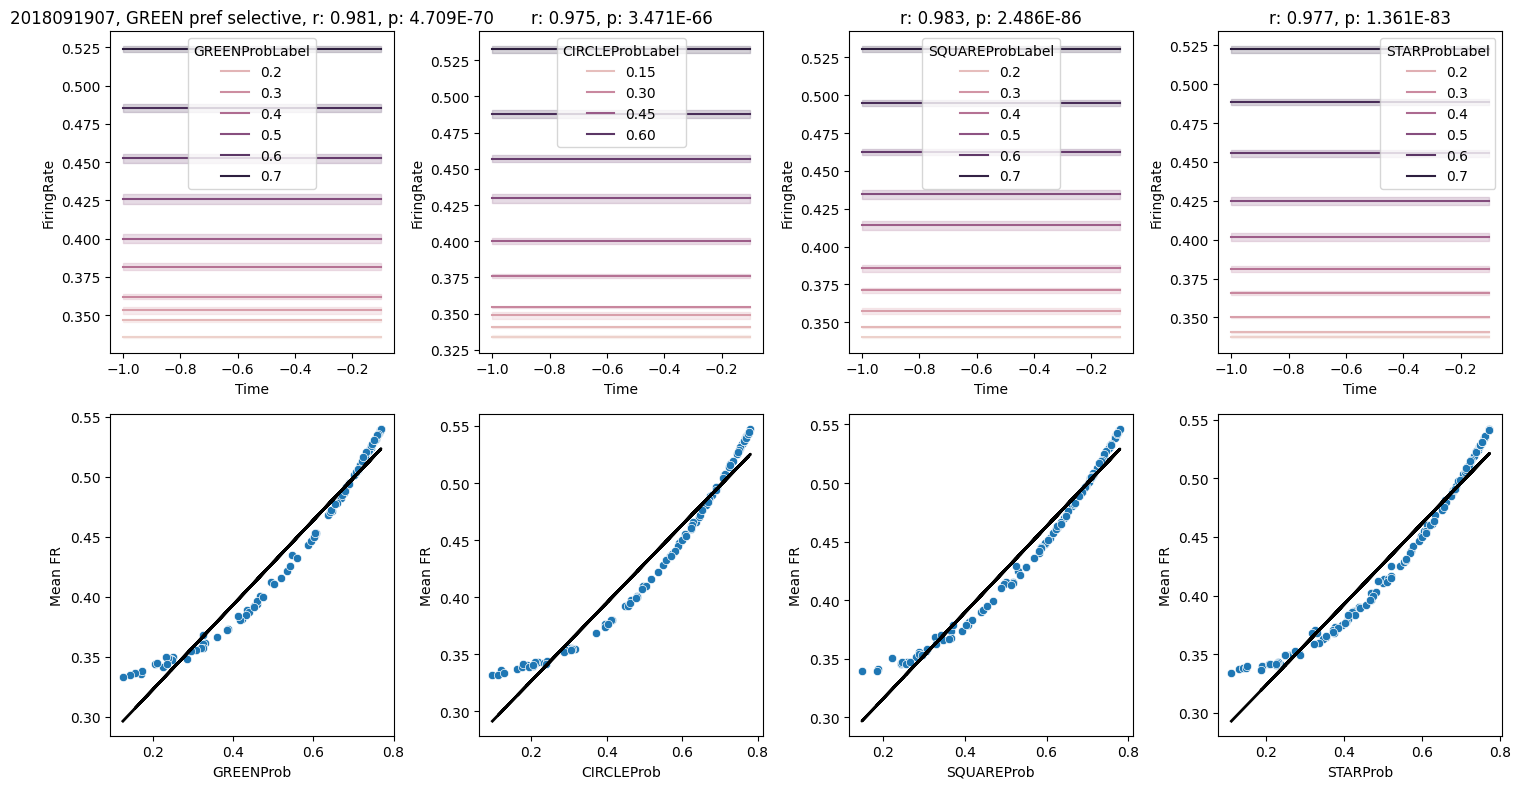

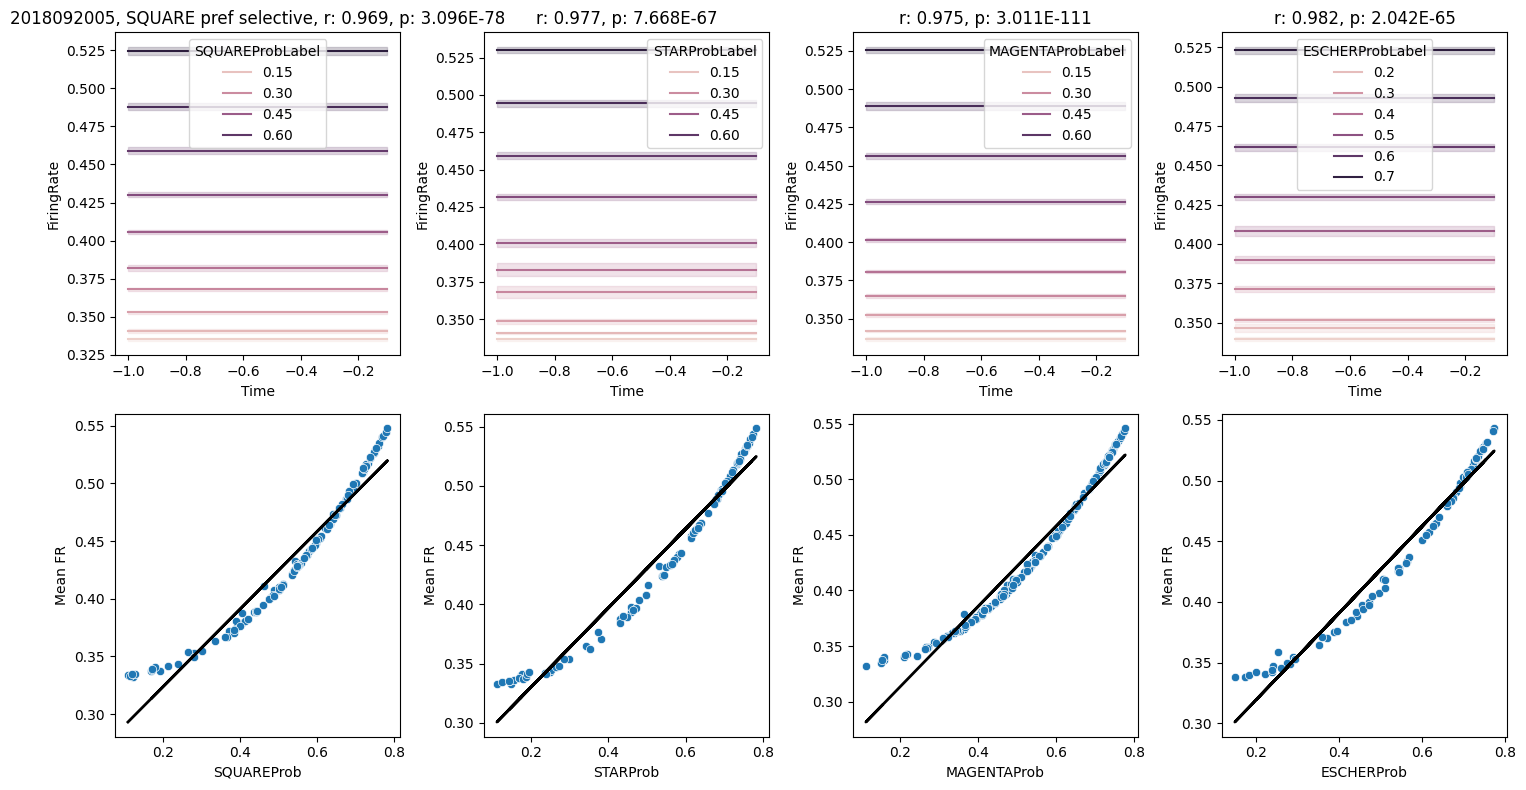

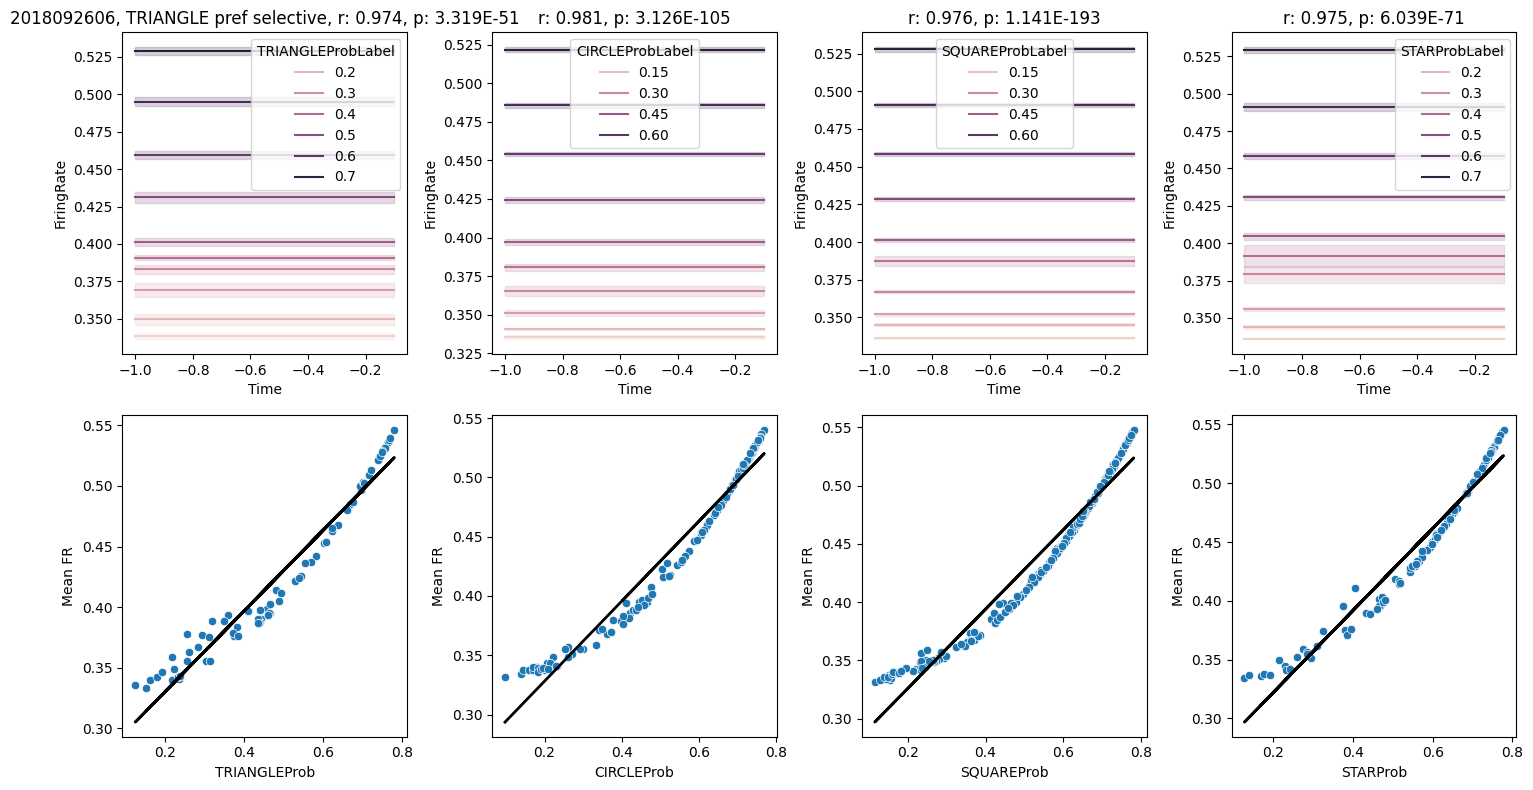

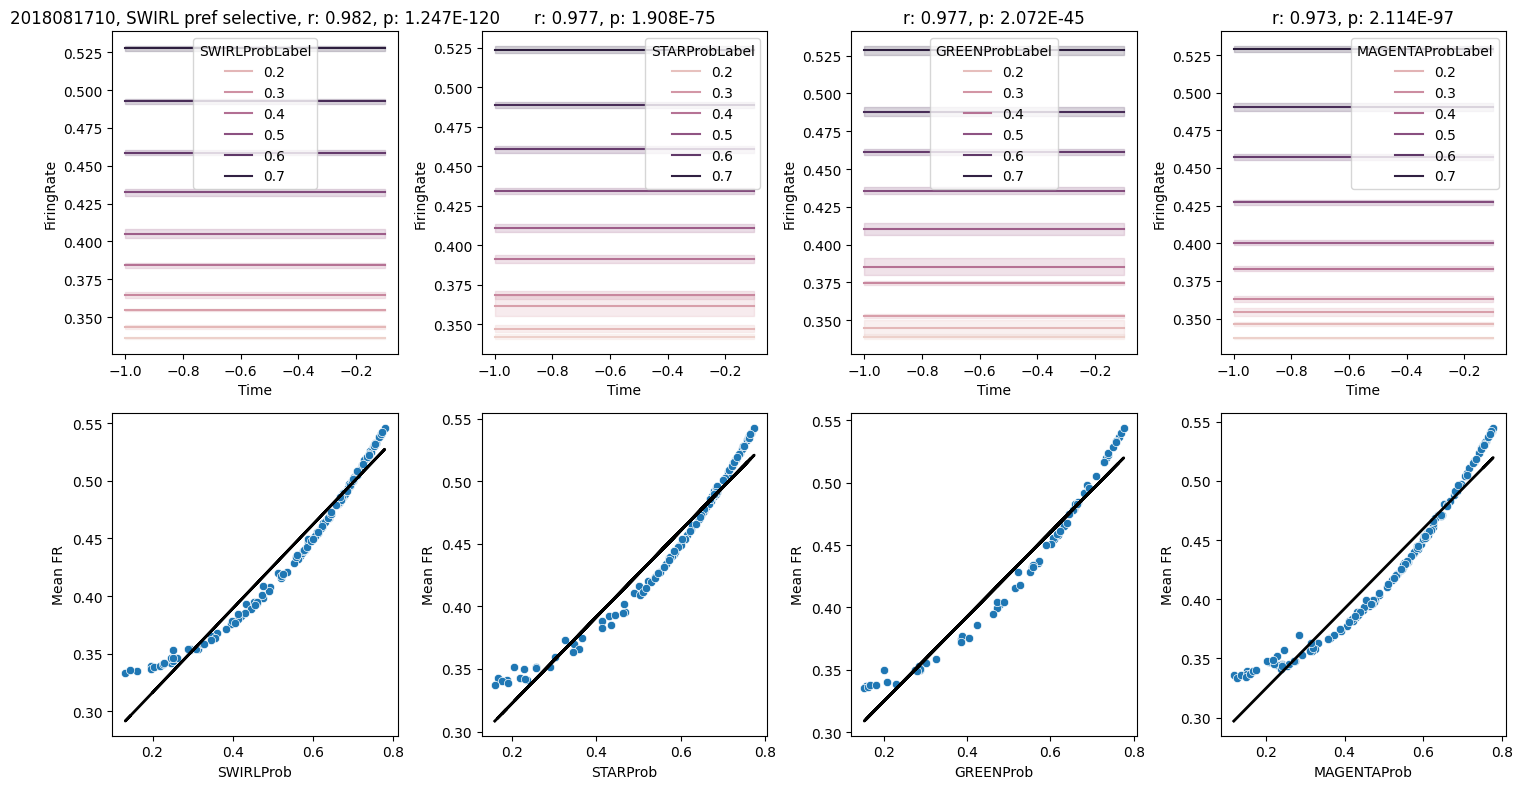

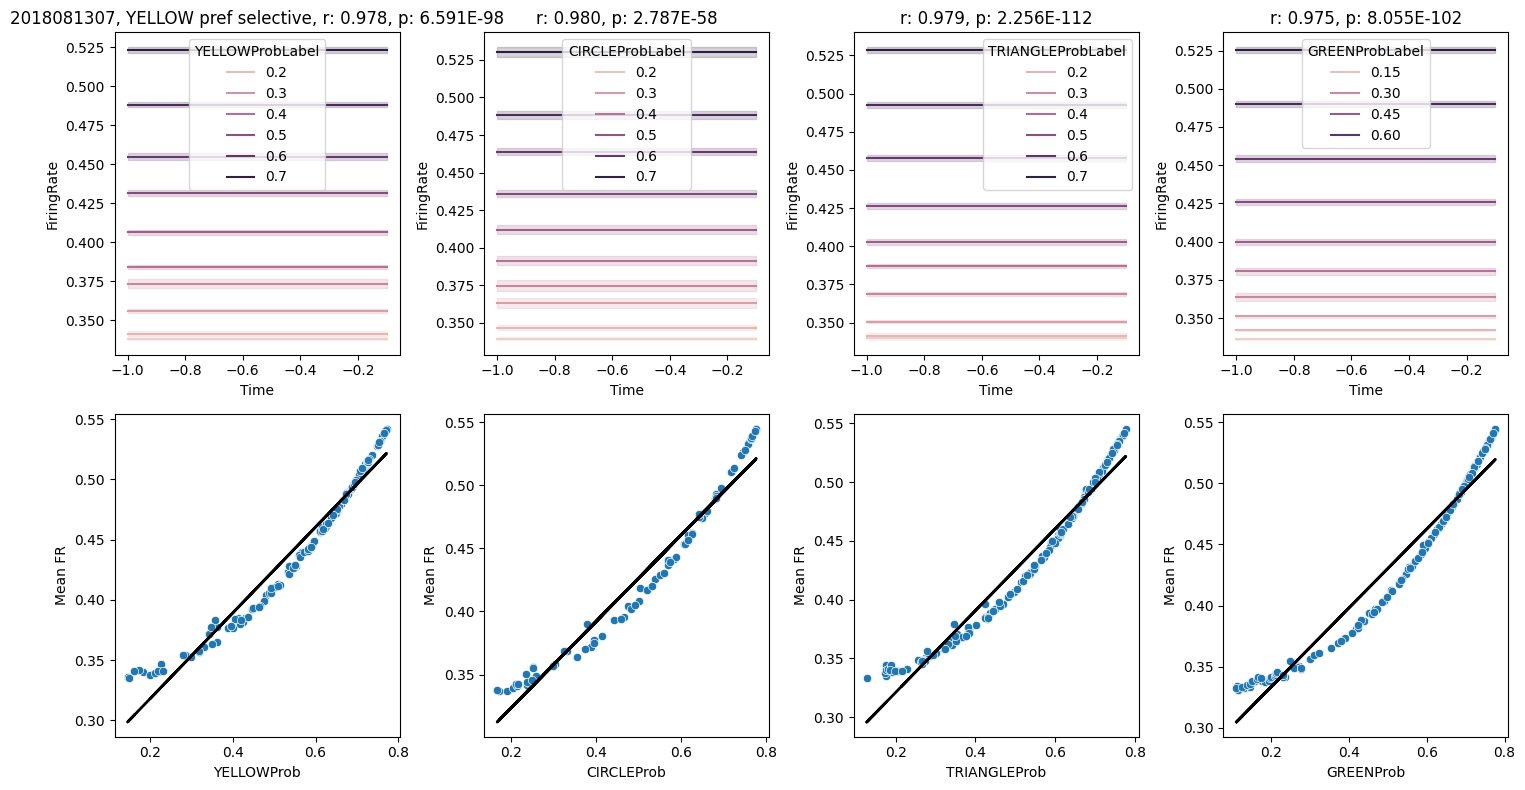

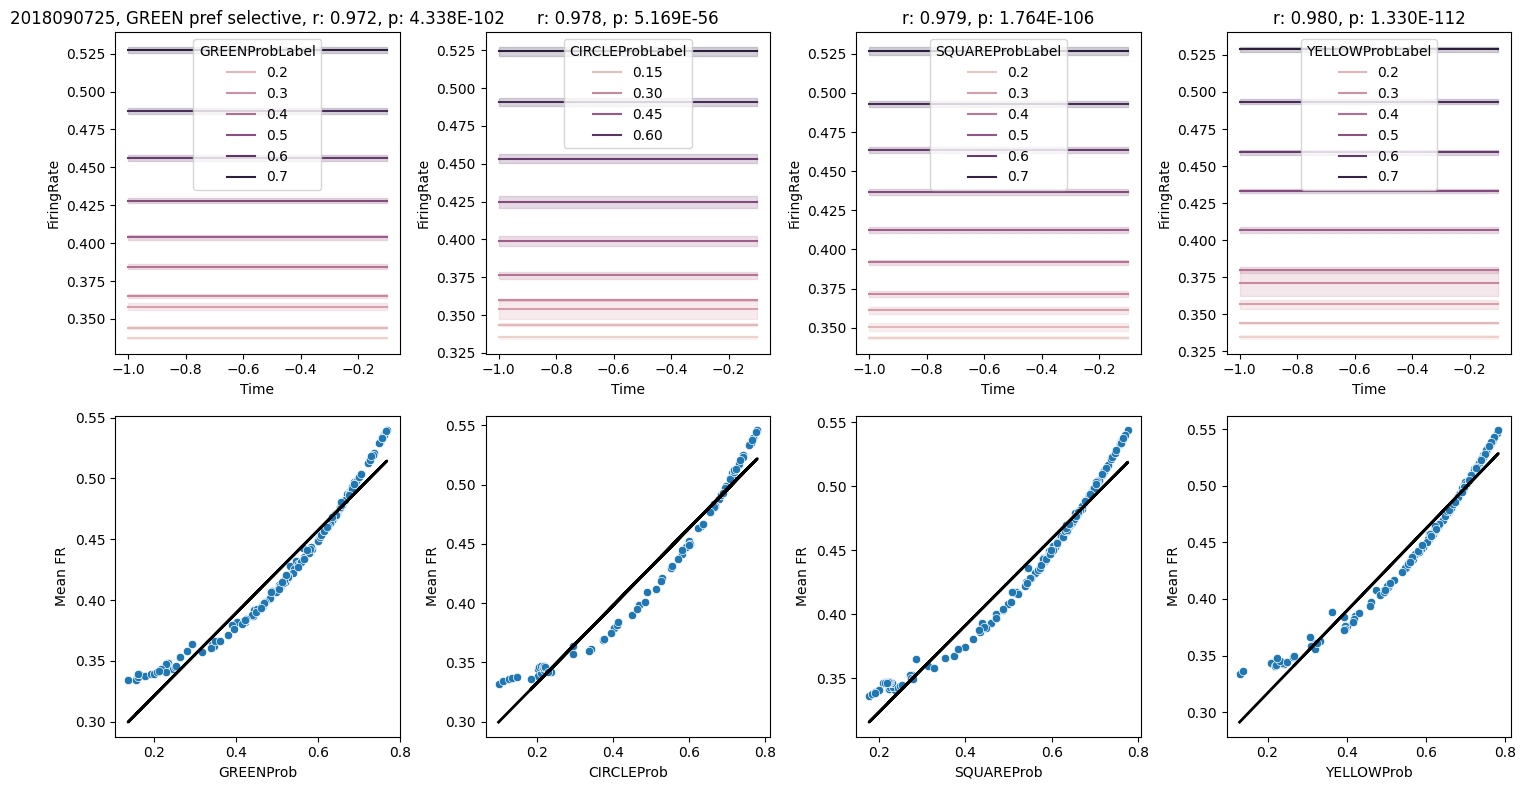

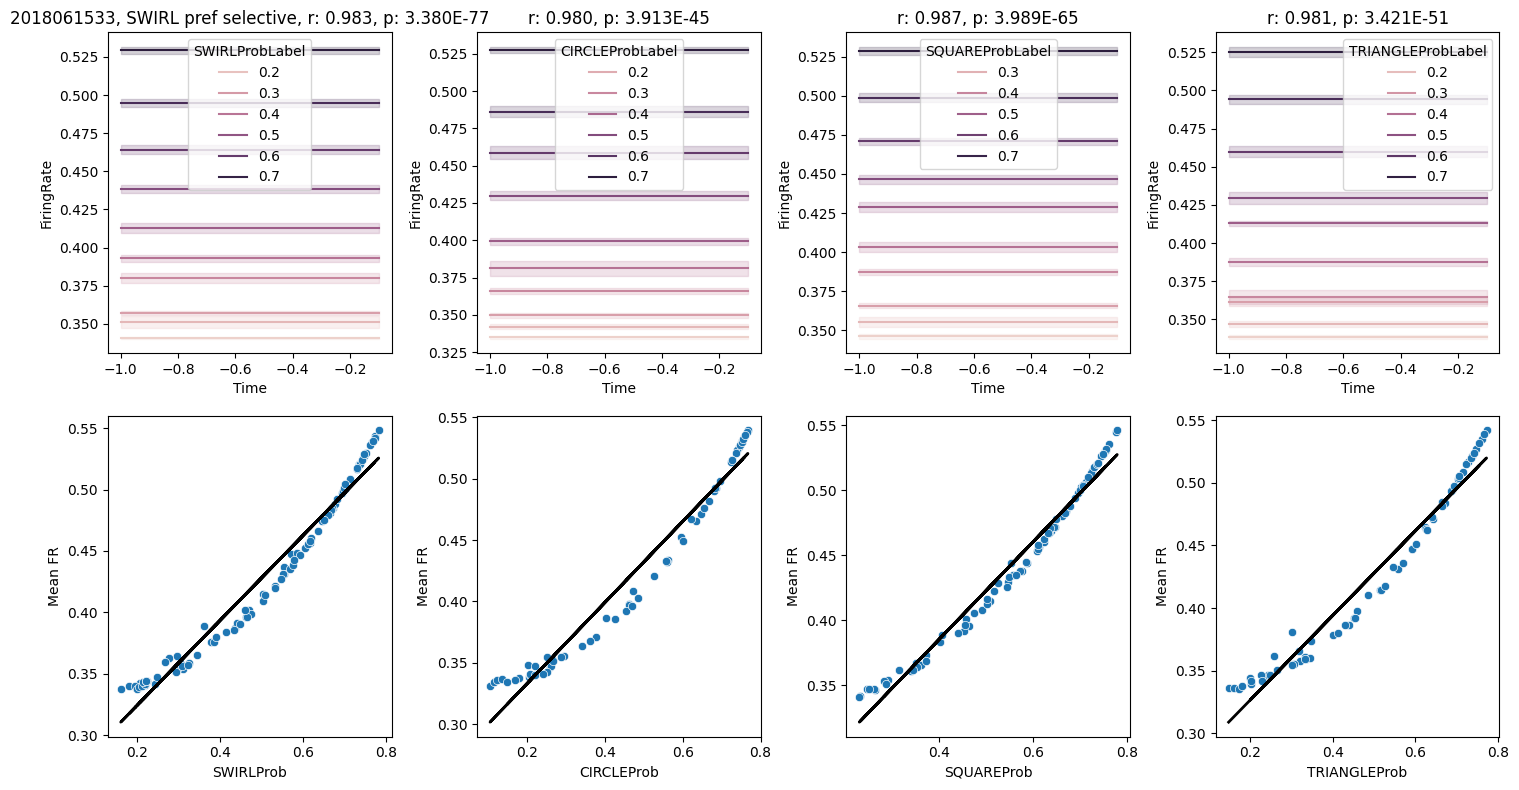

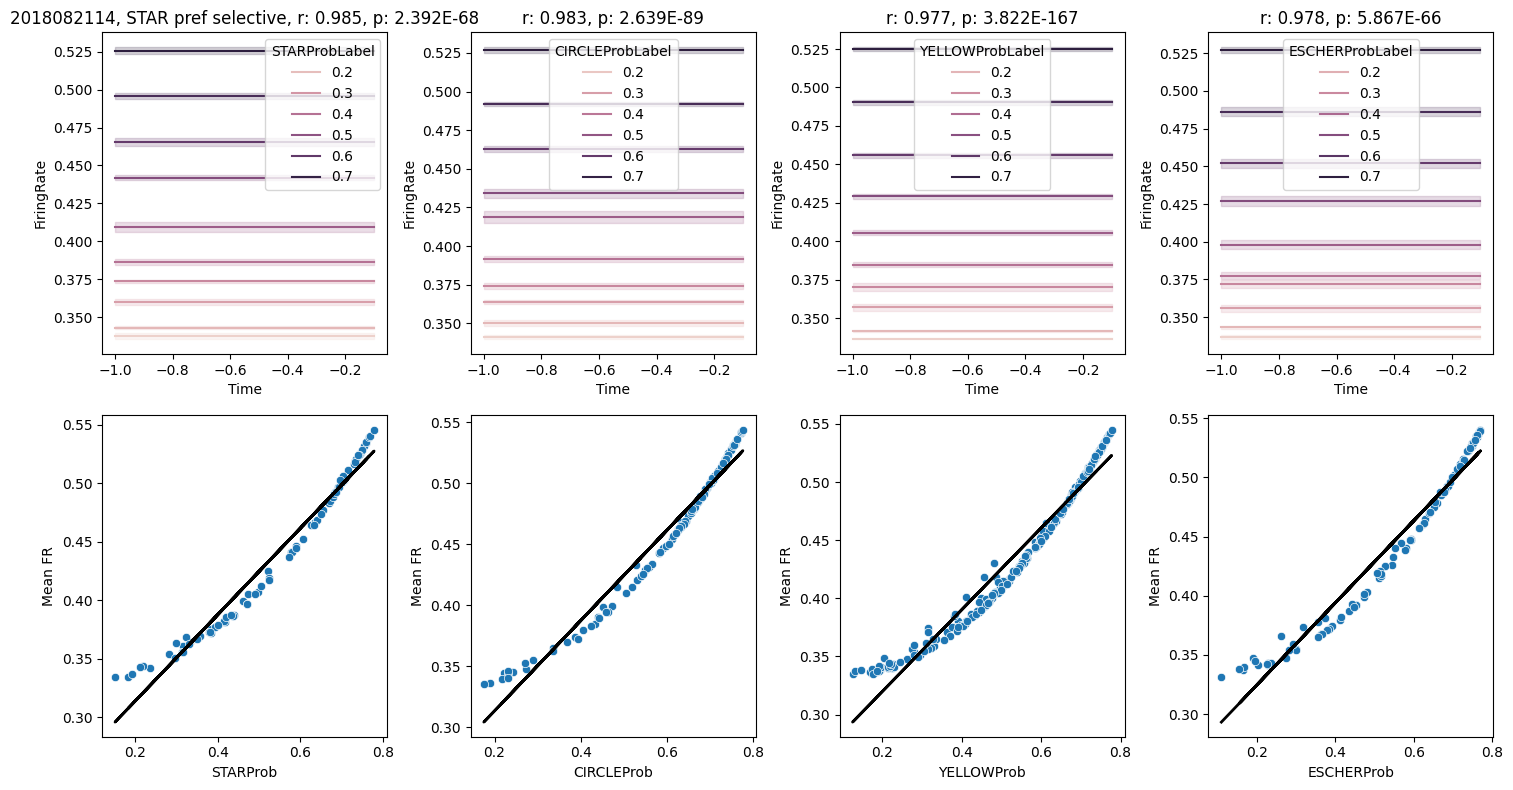

In [9]:
num_other_feats = 3
for i, row in to_vis.iterrows():
    other_feats = feat_sessions[(feat_sessions.session == row.session) & (feat_sessions.feat != row.feat)].feat
    if len(other_feats) < 3: 
        continue
    
    fig, axs = plt.subplots(2, 4, figsize=(15, 8))

    args.beh_filters = {}
    unit_id = row.PseudoUnitID
    args.feat = row.feat
    # args.beh_filters = {"PreferredBelief": row.feat, "PreferredChosen":True}
    args.beh_filters = {"PreferredBelief": row.feat}

    beh, frs = load_data(int(unit_id / 100), args, return_merged=False)
    frs = pd.merge(frs, beh[["TrialNumber", "BeliefStateValue"]], on="TrialNumber")
    frs["FiringRate"] = frs.BeliefStateValue

    visualization_utils.visualize_cond_psth(beh, frs, unit_id, f"{row.feat}Prob", axs[0, 0], num_bins=10)
    r, p = visualization_utils.visualize_cond_correlations(beh, frs, unit_id, f"{row.feat}Prob", axs[1, 0])
    axs[0, 0].set_title(f"{unit_id}, {row.feat} pref selective, r: {r:.3f}, p: {p:.3E}")

    for i, feat in enumerate(other_feats[:num_other_feats]):
        args.feat = feat
        # args.beh_filters = {"PreferredBelief": feat, "PreferredChosen":True}
        args.beh_filters = {"PreferredBelief": feat}

        beh, frs = load_data(int(unit_id / 100), args, return_merged=False)
        frs = pd.merge(frs, beh[["TrialNumber", "BeliefStateValue"]], on="TrialNumber")
        frs["FiringRate"] = frs.BeliefStateValue
        
        visualization_utils.visualize_cond_psth(beh, frs, unit_id, f"{feat}Prob", axs[0, i+1], num_bins=10)
        r, p = visualization_utils.visualize_cond_correlations(beh, frs, unit_id, f"{feat}Prob", axs[1, i+1])
        axs[0, i+1].set_title(f"r: {r:.3f}, p: {p:.3E}")

    fig.tight_layout()
    